In [1]:
import os
import glob
from functools import reduce

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

## Analysis
---

In [3]:
results_dir = "../../../../../results/apps/pub/vms/fanout/"
date_time_list = ["20170827035916.747697"]

message_size = 51*8 # in bits

cols = ['in (kbps)', 'out (kbps)'] 

In [4]:
dish_data_dict = {}
dish_data_dict['baseerat'] = {}
dish_data_dict['unicast'] = {}

for date_time in date_time_list:
    for i in glob.glob(results_dir + date_time + "/dish_stats_with__*"):
        scheme = i.split('__')[2].split('.')[1]
        if scheme == 'baseerat':
            dish_data_dict[scheme][1] = pd.read_csv(i, sep='\s*', header=None, skiprows=4, skipfooter=1, na_filter=False, names = cols)
        else:
            key = eval(i.split('__')[1].split('_')[1])
            dish_data_dict[scheme][key] = pd.read_csv(i, sep='\s*', header=None, skiprows=4, skipfooter=1, na_filter=False, names = cols)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/opt/conda/lib/python3.5/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/opt/conda/lib/python3.5/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [5]:
plot_data_dict = pd.DataFrame()

cols = [1, 2, 4, 8, 16, 32, 64, 128]

plot_data_dict['subscribers'] = cols

rows = []
for i in plot_data_dict['subscribers']:
    rows += [dish_data_dict['unicast'][i]['in (kbps)'].mean() / 1024]
plot_data_dict['unicast: throughput (mbps)'] = rows    

rows_rps = []
for i in plot_data_dict['subscribers']:
    rows_rps += [dish_data_dict['unicast'][i]['in (kbps)'].mean() / message_size]
plot_data_dict['unicast: throughput (krps)'] = rows_rps    

rows = []
for i in plot_data_dict['subscribers']:
    rows += [dish_data_dict['baseerat'][1]['in (kbps)'].mean() / 1024]
plot_data_dict['baseerat: throughput (mbps)'] = rows    

rows_rps = []
for i in plot_data_dict['subscribers']:
    rows_rps += [dish_data_dict['baseerat'][1]['in (kbps)'].mean() / message_size]
plot_data_dict['baseerat: throughput (krps)'] = rows_rps    

plot_data_dict = plot_data_dict.set_index('subscribers')

plot_data_dict

,unicast: throughput (mbps),unicast: throughput (krps),baseerat: throughput (mbps),baseerat: throughput (krps)
subscribers,,,,
1,49.901390,125.242705,51.697242,129.74994
2,34.005055,85.346021,51.697242,129.74994
4,17.584949,44.134773,51.697242,129.74994
8,3.915324,9.826694,51.697242,129.74994
16,1.809564,4.541652,51.697242,129.74994
32,0.990431,2.485788,51.697242,129.74994
64,0.533979,1.340183,51.697242,129.74994
128,0.270323,0.678459,51.697242,129.74994


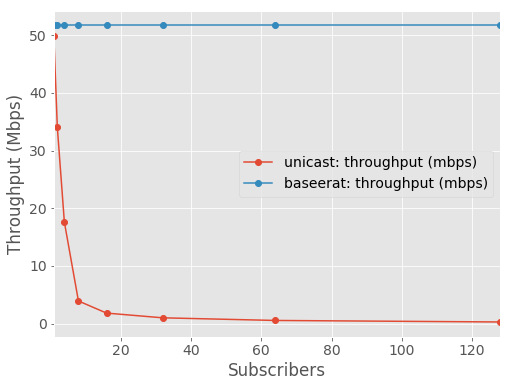

In [6]:
ax = plot_data_dict[['unicast: throughput (mbps)', 'baseerat: throughput (mbps)']].plot(kind='line', marker='o')
ax.set(xlabel='Subscribers', ylabel='Throughput (Mbps)')
plt.savefig('zmq-throughput.pdf')
plt.show()

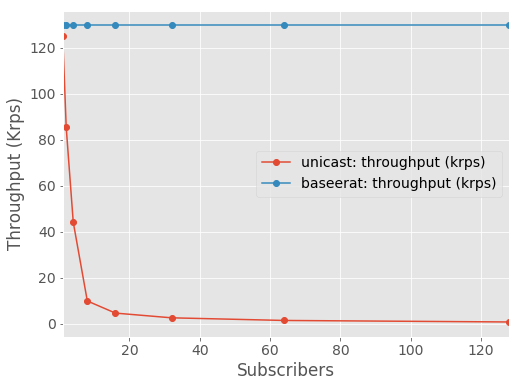

In [7]:
ax = plot_data_dict[['unicast: throughput (krps)', 'baseerat: throughput (krps)']].plot(kind='line', marker='o')
ax.set(xlabel='Subscribers', ylabel='Throughput (Krps)')
plt.savefig('zmq-throughput-krps.pdf')
plt.show()

---
CPU utilization with 1ms interval.

In [4]:
results_dir = "../../../../../results/apps/pub/vms/fanout/"
data_time = "20170827074947.700696"

cols = ['%cpu', '%mem'] 

In [5]:
radio_data_dict = {}
radio_data_dict['baseerat'] = {}
radio_data_dict['unicast'] = {}

for i in glob.glob(results_dir + data_time + "/radio_stats_with__*"):
    scheme = i.split('__')[2].split('.')[1]
    key = eval(i.split('__')[1].split('_')[1])
    radio_data_dict[scheme][key] = pd.read_csv(i, sep=' ', header=None, na_filter=False, names = cols)
        
# radio_data_dict

In [6]:
plot_data_dict = pd.DataFrame()

cols = [1, 2, 4, 8, 16, 32, 64, 128, 256]

plot_data_dict['subscribers'] = cols

rows = []
for i in plot_data_dict['subscribers']:
    rows += [radio_data_dict['unicast'][i]['%cpu'].mean()]
plot_data_dict['unicast: cpu utilization (%)'] = rows    

rows = []
for i in plot_data_dict['subscribers']:
    rows += [radio_data_dict['baseerat'][i]['%cpu'].mean()]
plot_data_dict['baseerat: cpu utilization (%)'] = rows    

plot_data_dict = plot_data_dict.set_index('subscribers')

plot_data_dict

,unicast: cpu utilization (%),baseerat: cpu utilization (%)
subscribers,,
1,4.780000,4.970000
2,4.880000,4.313043
4,5.970000,4.200000
8,7.570000,4.169231
16,10.780000,4.310526
32,18.740000,4.205556
64,32.050000,4.236842
128,60.030000,4.423810
256,90.572727,4.385000


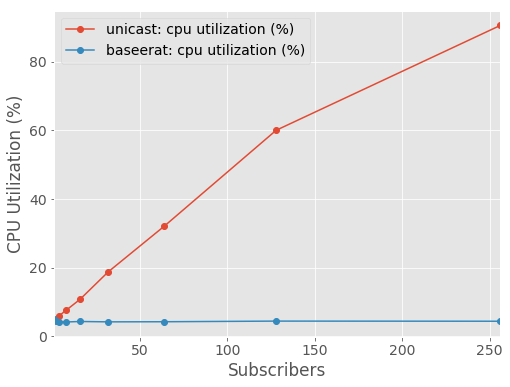

In [7]:
ax = plot_data_dict[['unicast: cpu utilization (%)', 'baseerat: cpu utilization (%)']].plot(kind='line', marker='o')
ax.set(xlabel='Subscribers', ylabel='CPU Utilization (%)')
# plt.savefig('zmq-cpu-util.pdf')
plt.show()

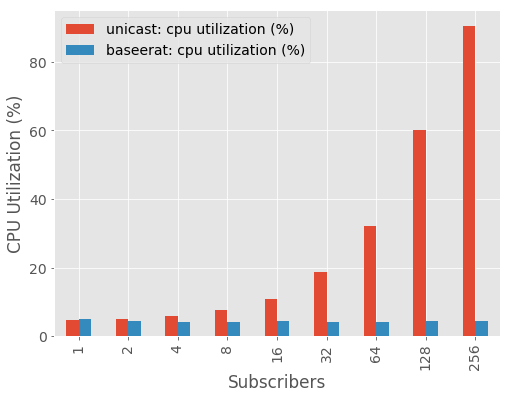

In [8]:
ax = plot_data_dict[['unicast: cpu utilization (%)', 'baseerat: cpu utilization (%)']].plot(kind='bar')
ax.set(xlabel='Subscribers', ylabel='CPU Utilization (%)')
# plt.savefig('zmq-cpu-util-barplot.pdf')
plt.show()

In [9]:
sns_plot_data = pd.DataFrame()

subscribers = [1, 2, 4, 8, 16, 32, 64, 128]

subs = []
rows = []
rows_rps = []
types = []

for i in subscribers:
    subs += [i for _ in range(len(dish_data_dict['unicast'][i]['in (kbps)']))]
    rows += list(dish_data_dict['unicast'][i]['in (kbps)'] / 1024)
    rows_rps += list(dish_data_dict['unicast'][i]['in (kbps)'] / message_size)
    types += ['Unicast' for _ in range(len(dish_data_dict['unicast'][i]['in (kbps)']))]

for i in subscribers:
    subs += [i for _ in range(len(dish_data_dict['baseerat'][1]['in (kbps)']))]
    rows += list(dish_data_dict['baseerat'][1]['in (kbps)'] / 1024)
    rows_rps += list(dish_data_dict['baseerat'][1]['in (kbps)'] / message_size)
    types += ['Baseerat' for _ in range(len(dish_data_dict['baseerat'][1]['in (kbps)']))]
    
sns_plot_data['subscribers'] = subs
sns_plot_data['bandwidth (mbps)'] = rows
sns_plot_data['bandwidth (krps)'] = rows_rps
sns_plot_data[''] = types

# plot_data_dict

NameError: name 'dish_data_dict' is not defined

In [10]:
sns_plot_data['bandwidth (mbps)'].where(sns_plot_data[''] == 'Baseerat').describe()

KeyError: 'bandwidth (mbps)'

In [68]:
sns_plot_data['bandwidth (krps)'].where(sns_plot_data[''] == 'Baseerat').mean()

129.74993999323868

In [71]:
sns_plot_data['bandwidth (mbps)'].where(sns_plot_data[''] == 'Unicast').describe()

count    284.000000
mean      11.806417
std       16.954792
min        0.209092
25%        0.409402
50%        1.758755
75%       18.084963
max       53.711396
Name: bandwidth (mbps), dtype: float64

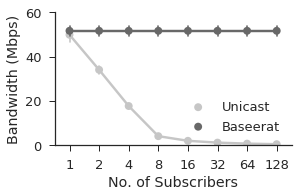

In [63]:
sns.set(style='ticks', font_scale=1.3, rc={"lines.linewidth": 0.9})
ax = sns.factorplot(x='subscribers', y='bandwidth (mbps)', hue='', data=sns_plot_data, palette="Greys",
                   size=3, kind="point", legend=True, legend_out=False, aspect=1.5, ci='sd', scale=1.5)
ax.set(xlabel='No. of Subscribers', ylabel='Bandwidth (Mbps)')
ax.set(ylim=(0, 60))
plt.savefig('zmq-bandwidth-mbps.pdf')
plt.show()

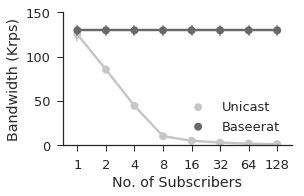

In [66]:
sns.set(style='ticks', font_scale=1.3, rc={"lines.linewidth": 0.9})
ax = sns.factorplot(x='subscribers', y='bandwidth (krps)', hue='', data=sns_plot_data, palette="Greys",
                   size=3, kind="point", legend=True, legend_out=False, aspect=1.5, ci='sd', scale=1.5)
ax.set(xlabel='No. of Subscribers', ylabel='Bandwidth (Krps)')
ax.set(ylim=(0, 150))
plt.savefig('zmq-bandwidth-krps.pdf')
plt.show()

In [11]:
sns_plot_data = pd.DataFrame()

subscribers = [1, 2, 4, 8, 16, 32, 64, 128, 256]

subs = []
rows = []
types = []

for i in subscribers:
    subs += [i for _ in range(len(radio_data_dict['unicast'][i]['%cpu']))]
    rows += list(radio_data_dict['unicast'][i]['%cpu'])
    types += ['Unicast' for _ in range(len(radio_data_dict['unicast'][i]['%cpu']))]

for i in subscribers:
    subs += [i for _ in range(len(radio_data_dict['baseerat'][i]['%cpu']))]
    rows += list(radio_data_dict['baseerat'][i]['%cpu'])
    types += ['Baseerat' for _ in range(len(radio_data_dict['baseerat'][i]['%cpu']))]
    
sns_plot_data['subscribers'] = subs
sns_plot_data['%cpu'] = rows
sns_plot_data[''] = types

# plot_data_dict

In [12]:
sns_plot_data['%cpu'].where(sns_plot_data[''] == 'Baseerat').where(sns_plot_data['subscribers'] == 1).describe()

count    10.000000
mean      4.970000
std       0.397352
min       4.300000
25%       4.700000
50%       5.000000
75%       5.225000
max       5.700000
Name: %cpu, dtype: float64

In [13]:
sns_plot_data['%cpu'].where(sns_plot_data[''] == 'Unicast').where(sns_plot_data['subscribers'] == 64).describe()

count    10.000000
mean     32.050000
std       0.397911
min      31.600000
25%      31.600000
50%      32.300000
75%      32.300000
max      32.600000
Name: %cpu, dtype: float64

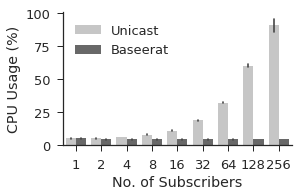

In [14]:
sns.set(style='ticks', font_scale=1.3, rc={"lines.linewidth": 0.9})
ax = sns.factorplot(x='subscribers', y='%cpu', hue='', data=sns_plot_data, palette="Greys",
                   size=3, kind="bar", legend=True, legend_out=False, aspect=1.5, ci='sd')
ax.set(xlabel='No. of Subscribers', ylabel='CPU Usage (%)')
plt.savefig('zmq-cpu-usage.pdf')
plt.show()